In [127]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [128]:
class WindowGenerator():
    def __init__(self,
                 input_width,
                 label_width,
                 shift,
                 train_df,
                 val_df,
                 test_df,
                 label_columns=None):
        #raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size : {self.total_window_size}',
            f'Input indices : {self.input_indices}',
            f'Label indices : {self.label_indices}',
            f'Label column name(s) : {self.label_columns}'
        ])

In [129]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
    #set shape manually to make the tf.data.Dataset objetcs easier to inspect
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

In [130]:
WindowGenerator.split_window = split_window

In [131]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    return ds

In [132]:
WindowGenerator.make_dataset = make_dataset

In [133]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of inputs, labels for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the train dataset
        result = next(iter(self.train))
        # Cache it
        self._example = result
    
    return result

In [134]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [135]:
class BaseLine(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [136]:
def plot(self, model, plot_col, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12,8))
    plot_col_index = self.column_indices[plot_col]
    
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')

In [137]:
WindowGenerator.plot = plot

In [138]:
MAX_EPOCHS = 20

In [139]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

# 

In [140]:
data_raw = pd.read_table('data/MSFT.csv', sep=',')
high_raw = data_raw.loc[:, ['High']]
december_2020 = high_raw[1489:]
high_raw = high_raw[:1489]

In [141]:
n = len(high_raw)

high_test = high_raw[1389:]
high_raw = high_raw[:1389]

high_train = high_raw[:int(n*0.8)]
high_val = high_raw[int(n*0.8):]

In [142]:
high_mean = np.mean(high_raw)
high_std = np.std(high_raw)

high_train = (high_train - high_mean) / high_std
high_test = (high_test - high_mean) / high_std
high_val = (high_val - high_mean) / high_std

In [153]:
plot_time = data_raw[-22:]

In [155]:
plot_time = pd.to_datetime(plot_time['Date'])

# 

In [145]:
window = WindowGenerator(
    input_width=12,
    label_width=1,
    shift=1,
    train_df=high_train,
    val_df=high_val,
    test_df=high_test,
    label_columns=['High']
)

In [146]:
window

Total window size : 13
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [12]
Label column name(s) : ['High']

#

In [147]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape((1, -1))
])

In [148]:
history = compile_and_fit(multi_step_dense, window)

Epoch 1/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0303 - mean_absolute_error: 0.1179 - val_loss: 0.0355 - val_mean_absolute_error: 0.1482
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0383 - val_loss: 0.0245 - val_mean_absolute_error: 0.1159
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0305 - val_loss: 0.0159 - val_mean_absolute_error: 0.0890
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0275 - val_loss: 0.0132 - val_mean_absolute_error: 0.0749
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0251 - val_loss: 0.0103 - val_mean_absolute_error: 0.0710
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0229 - val_loss: 0.0089 - val_mean_absolute_error: 0.0679
Epoch 7/20
37/37 [==========

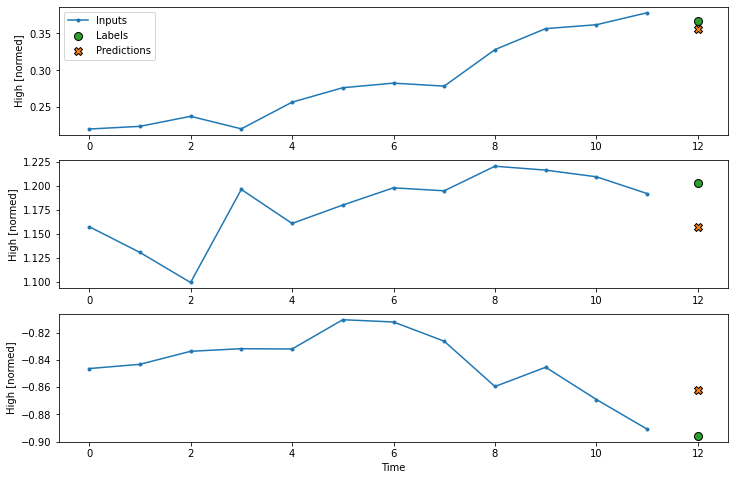

In [149]:
window.plot(multi_step_dense, plot_col='High')

In [150]:
len(december_2020)

22

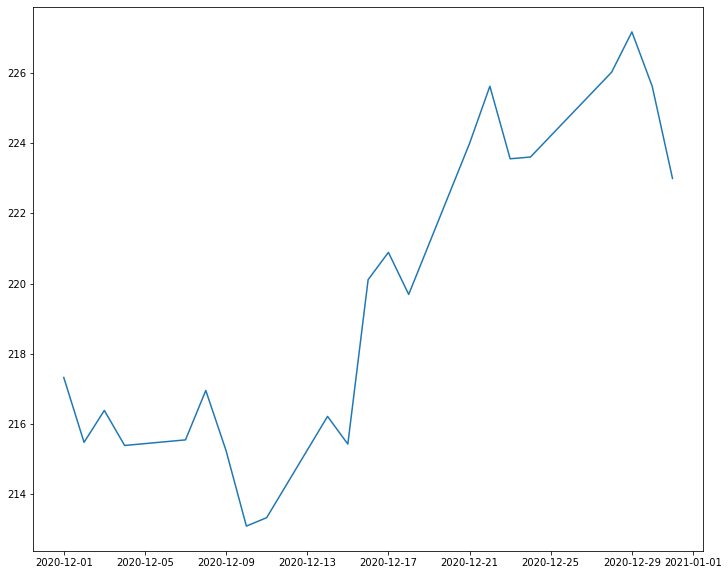

In [156]:
fig, ax = plt.subplots(figsize=(12,10))
plt.plot(plot_time, december_2020)

In [157]:
#initialize
steps = 22
plot_index = list(range(0, steps))
sim_sample = np.zeros(steps)

#initial model input
model_input = high_test['High'][-12:].to_list()

In [158]:
model_input_tensor = tf.constant([model_input])
model_input_tensor

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[3.0735672, 3.0331137, 3.0407736, 3.0393372, 2.979256 , 2.928031 ,
        2.9342544, 2.9103177, 2.957234 , 2.9821281, 3.0055866, 2.9694417]],
      dtype=float32)>

In [159]:
for i in range(0, steps):
    #model output
    sim = multi_step_dense(model_input_tensor)
    sim_num = sim.numpy()[0][0][0]
    #add it to predictions
    sim_sample[i] = sim_num
    #new model input
    model_input.pop(0)
    model_input.append(sim_num)
    model_input_tensor = tf.constant([model_input])

In [160]:
sim_plot = sim_sample * high_std[0] + high_mean[0]

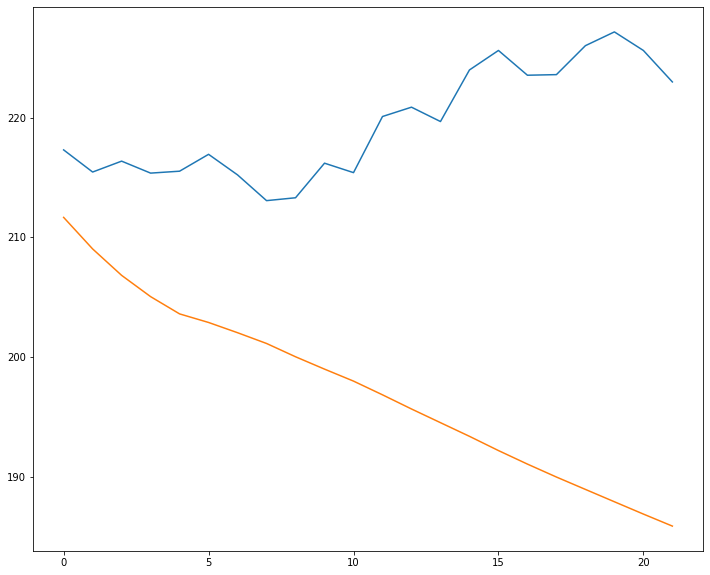

In [161]:
fig, ax = plt.subplots(figsize=(12,10))
plt.plot(plot_index, december_2020, label="Actual data")
plt.plot(plot_index, sim_plot, label="Dense network simulation")

#

In [170]:
def simulate_sample(steps, model_input):
    #initialization
    history = compile_and_fit(multi_step_dense, window)
    result = np.zeros(steps)
    model_input_tensor = tf.constant([model_input])
    
    for i in range(0, steps):
        sim = multi_step_dense(model_input_tensor)
        sim_num = sim.numpy()[0][0][0]
        result[i] = sim_num
        model_input.pop(0)
        model_input.append(sim_num)
        model_input_tensor = tf.constant([model_input])
    
    return result

In [171]:
sim_array = []
num_sim = 20

In [172]:
%%capture

for i in range(0,num_sim):
    model_input = high_test['High'][-12:].to_list()
    sim = simulate_sample(22, model_input)
    sim_array.append(sim)

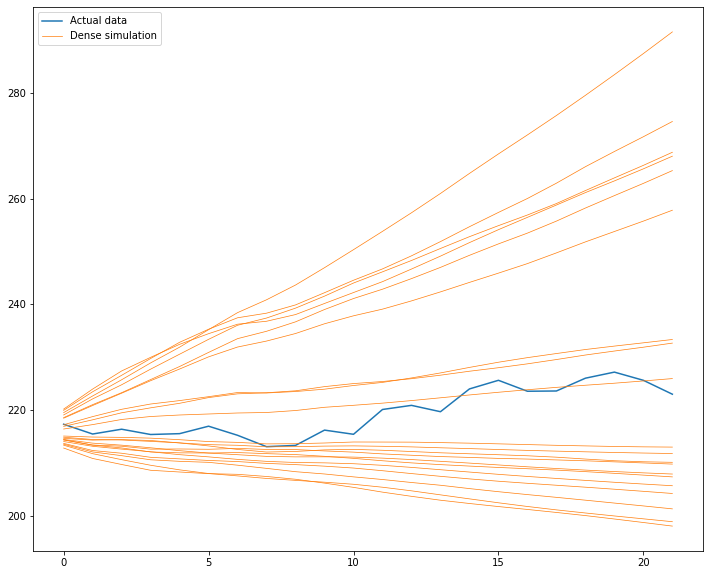

In [173]:
fig, ax = plt.subplots(figsize=(12,10))
plt.plot(plot_index, december_2020)

for i in range(0, num_sim):
    plot_sim = sim_array[i]*high_std[0]+high_mean[0]
    plt.plot(plot_index, plot_sim, c='tab:orange', lw=0.7)

plt.legend(labels=['Actual data', 'Dense simulation'])